# Bayesian parameter estimation for synthetic data

## Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as math
import scipy as sp
import time
import seaborn as sns
from scipy.integrate import solve_ivp
from cholesky import cholesky
from tqdm import trange

## Necessary functions

In [6]:
def pred_prey(t, population, params):
    prey, predator = population
    dpdt = params[0] * prey - params[1] * prey * predator
    drdt = -params[2] * predator + params[3] * prey * predator
    return [dpdt, drdt] 

def pred_prey_model(params, t_eval):
    z0 = [params[4], params[5]]  # initial conditions for prey and predator
    def ode(t, z):
        return pred_prey(t, z, params)  
    t_span = (t_eval[0], t_eval[-1])
    sol = solve_ivp(ode, t_span, z0, t_eval=t_eval, method='RK45')
    return sol

def log_likelihood(params, t, model, data):
    try:
        solution = model(params, t)
        if not solution.success:
            return -np.inf

        y_model = solution.y.T
        min_len = min(data.shape[0], y_model.shape[0])

        # clamp to positive for log
        data_prey = np.maximum(data[:min_len, 0], 1e-8)
        data_pred = np.maximum(data[:min_len, 1], 1e-8)
        model_prey = np.maximum(y_model[:min_len, 0], 1e-8)
        model_pred = np.maximum(y_model[:min_len, 1], 1e-8)

        # log-residuals
        log_resid_prey = np.log(data_prey) - np.log(model_prey)
        log_resid_pred = np.log(data_pred) - np.log(model_pred)

        # estimate sigma from log-residuals (pooled for both species)
        sigma_prey = np.std(log_resid_prey)
        sigma_pred = np.std(log_resid_pred)
        sigma = np.mean([sigma_prey, sigma_pred]) + 1e-6  # avoid zero

        # lognormal likelihood
        loglike_prey = -0.5 * np.sum((log_resid_prey) ** 2 / sigma ** 2)
        loglike_pred = -0.5 * np.sum((log_resid_pred) ** 2 / sigma ** 2)
        loglike_prey -= min_len * np.log(sigma * np.sqrt(2 * np.pi))
        loglike_pred -= min_len * np.log(sigma * np.sqrt(2 * np.pi))

        return loglike_prey + loglike_pred
    except Exception as e:
        print(f"Error in lognormal log-likelihood: {e}")
        return -np.inf

def log_prior(params, initial):
    if len(params) != 6:
        print('Rejected: wrong length', params)
        return -np.inf
    if np.any(params <= 0):
        print("Rejected: negative param", params)
        return -np.inf
    # ...existing code...
    a_mean, a_std = initial[0], 0.5
    b_mean, b_std = initial[1], 0.05
    c_mean, c_std = initial[2], 0.5
    d_mean, d_std = initial[3], 0.05

    prey0_mean, prey0_std = initial[4], 2
    pred0_mean, pred0_std = initial[5], 2

    a_mu = np.log(a_mean**2 / np.sqrt(a_std**2 + a_mean**2))
    a_sigma = np.sqrt(np.log(1 + (a_std**2) / (a_mean**2)))
    b_mu = np.log(b_mean**2 / np.sqrt(b_std**2 + b_mean**2))
    b_sigma = np.sqrt(np.log(1 + (b_std**2) / (b_mean**2)))
    c_mu = np.log(c_mean**2 / np.sqrt(c_std**2 + c_mean**2))
    c_sigma = np.sqrt(np.log(1 + (c_std**2) / (c_mean**2)))
    d_mu = np.log(d_mean**2 / np.sqrt(d_std**2 + d_mean**2))
    d_sigma = np.sqrt(np.log(1 + (d_std**2) / (d_mean**2)))

    a_prior = sp.stats.lognorm.logpdf(params[0], s=a_sigma, scale=np.exp(a_mu))
    b_prior = sp.stats.lognorm.logpdf(params[1], s=b_sigma, scale=np.exp(b_mu))
    c_prior = sp.stats.lognorm.logpdf(params[2], s=c_sigma, scale=np.exp(c_mu))
    d_prior = sp.stats.lognorm.logpdf(params[3], s=d_sigma, scale=np.exp(d_mu))
    prey0_prior = np.log(sp.stats.norm.pdf(params[4], loc=prey0_mean, scale=prey0_std))
    pred0_prior = np.log(sp.stats.norm.pdf(params[5], loc=pred0_mean, scale=pred0_std))

    if not all(np.isfinite([a_prior, b_prior, c_prior, d_prior, prey0_prior, pred0_prior])):
        return -np.inf

    return a_prior + b_prior + c_prior + d_prior + prey0_prior + pred0_prior

def log_posterior(params, t, model, data, initial):
    like = log_likelihood(params, t, model, data)
    prior = log_prior(params, initial)
    return like + prior

def prop(current, C):
    z = np.random.randn(6)
    proposal = current + 0.6 * C @ z
    return proposal

def acceptance_prob(current, proposal, t, model, data, initial):
    try:
        lp_proposal = log_posterior(proposal, t, model, data, initial)
        lp_current = log_posterior(current, t, model, data, initial)
        if not np.isfinite(lp_proposal) or not np.isfinite(lp_current):
            return 0  # reject if nan or inf
        beta = lp_proposal - lp_current
        alpha = min(1, np.exp(beta))
        return alpha
    except:
        return 0  # reject if there's an error


def metropolis_hastings(data, initial, model, t, iterations=1000):
    df_chol = pd.DataFrame(data, columns=['prey', 'pred'])
    C = cholesky(df_chol, initial, t, pred_prey)

    samples = [initial.copy()]
    current = initial.copy()
    accepted = 0
    start = time.time()

    for i in trange(iterations, desc="MCMC Progress"):
        proposal = prop(current, C)
        alpha = acceptance_prob(current, proposal, t, model, data, initial)
        if alpha > 0 and -2 * np.log(np.random.rand()) > -2 * np.log(alpha):
            current = proposal.copy()
            accepted += 1
        samples.append(current.copy())
    total_time = time.time() - start
    print(f"Final acceptance rate: {accepted/iterations:.3f}")
    print(f"Total runtime: {total_time:.1f} seconds")
    return np.array(samples)


## Running MCMC (first round)

In [25]:
np.random.seed(42)
model = pred_prey_model

# Load CSV with only two columns: prey, pred
df = pd.read_csv(r"C:\Users\lebda\source\repos\reu\final\synthetic\parameter_estimation\pred_prey_synthetic_data_noisy.csv", names=['prey', 'pred'], header=None)
df['prey'] = pd.to_numeric(df['prey'], errors='coerce')
df['pred'] = pd.to_numeric(df['pred'], errors='coerce')
df = df.dropna(subset=['prey', 'pred'])

# Generate time column (assuming each row is a consecutive time step, e.g., year)
df = df.reset_index(drop=True)
df['time'] = np.arange(len(df))

# Use first 20 valid rows for estimation and plotting
data_est = df[['prey', 'pred']].values[:20]
t_eval_est = df['time'].values[:20]

data_plot = data_est
t_eval_plot = t_eval_est

# For MCMC, use initial guess from frequentist optimizer
#initial = np.array([1.353, 0.1125, 0.5422, 0.04684, 18.59, 9.312])
initial = np.load('frequentist_parameters.npy')
print(f"Initial parameters: {initial}")

Initial parameters: [ 1.51287216  0.12417922  0.47399017  0.03958988 20.31683626 10.70013124]


In [8]:
# Run MCMC using all 20 valid points with diagnostics
for_debug = True
samples = [initial.copy()]
current = initial.copy()
accepted = 0
start = time.time()
for i in trange(5000, desc="MCMC Progress"):
    proposal = prop(current, cholesky(pd.DataFrame(data_est, columns=['prey', 'pred']), initial, t_eval_est, pred_prey))
    alpha = acceptance_prob(current, proposal, t_eval_est, model, data_est, initial)
    if for_debug and i < 20:
        print(f"Iteration {i}: proposal={proposal}")
        print(f"  acceptance prob={alpha}")
        print(f"  log_posterior(proposal)={log_posterior(proposal, t_eval_est, model, data_est, initial)}")
        print(f"  log_posterior(current)={log_posterior(current, t_eval_est, model, data_est, initial)}")
    if alpha > 0 and -2 * np.log(np.random.rand()) > -2 * np.log(alpha):
        current = proposal.copy()
        accepted += 1
    samples.append(current.copy())
total_time = time.time() - start
print(f"Final acceptance rate: {accepted/5000:.3f}")
print(f"Total runtime: {total_time:.1f} seconds")
samples = np.array(samples)

MCMC Progress:   0%|          | 7/5000 [00:00<02:36, 31.85it/s]

Iteration 0: proposal=[ 1.7825317   0.14690915  0.39220568  0.03415812 20.03085984 10.56898539]
  acceptance prob=2.9897362203120393e-06
  log_posterior(proposal)=-1.1227934644451614
  log_posterior(current)=11.597531930639612
Iteration 1: proposal=[ 1.31492453  0.10800487  0.53828876  0.04452378 19.4980985  10.18252978]
  acceptance prob=0.0005639596553296358
  log_posterior(proposal)=4.117004088511299
  log_posterior(current)=11.597531930639612
Iteration 2: proposal=[ 1.46337407  0.11843373  0.51559359  0.04258186 19.0349886   9.9090653 ]
  acceptance prob=1
  log_posterior(proposal)=14.088759469541792
  log_posterior(current)=11.597531930639612
Iteration 3: proposal=[ 1.64329637  0.13267611  0.4669369   0.04176804 18.96571028  9.62035715]
  acceptance prob=0.0008319438311825345
  log_posterior(proposal)=6.997013839521868
  log_posterior(current)=14.088759469541792
Iteration 4: proposal=[ 1.72930905  0.13965426  0.45073078  0.03704768 18.66060959  9.31661547]
  acceptance prob=0.0003

MCMC Progress:   0%|          | 15/5000 [00:00<02:23, 34.65it/s]

  log_posterior(current)=14.088759469541792
Iteration 8: proposal=[ 1.71634703  0.13498828  0.45174391  0.03645063 19.36607411 10.30232284]
  acceptance prob=0.22388931571217055
  log_posterior(proposal)=17.9885842995931
  log_posterior(current)=19.485187775125773
Iteration 9: proposal=[ 1.56149969  0.12687411  0.48464428  0.03996182 18.91288854 10.36385545]
  acceptance prob=1
  log_posterior(proposal)=20.777600805352193
  log_posterior(current)=19.485187775125773
Iteration 10: proposal=[ 1.75520049  0.13749772  0.41687921  0.03623821 16.8928677  10.8242232 ]
  acceptance prob=1.4970859245316958e-08
  log_posterior(proposal)=2.760440563006892
  log_posterior(current)=20.777600805352193
Iteration 11: proposal=[ 1.54193682  0.12316516  0.51062085  0.04371436 17.93093241  9.52643911]
  acceptance prob=0.0028968273864040275
  log_posterior(proposal)=14.933461659814279
  log_posterior(current)=20.777600805352193
Iteration 12: proposal=[ 1.68710149  0.13546893  0.44879966  0.03847448 18.623

MCMC Progress:   0%|          | 19/5000 [00:00<02:50, 29.14it/s]

Iteration 15: proposal=[ 1.35844617  0.10830561  0.53254874  0.04561568 18.27597566 11.43774085]
  acceptance prob=0.02293991736156939
  log_posterior(proposal)=17.611550956965452
  log_posterior(current)=21.38642772662559
Iteration 16: proposal=[ 2.17595743  0.17011924  0.31350155  0.0280408  18.55769953 10.82025319]
  acceptance prob=2.1279822818284828e-16
  log_posterior(proposal)=-14.699759516042825
  log_posterior(current)=21.38642772662559
Iteration 17: proposal=[ 1.51740484  0.1215685   0.49041639  0.04298094 18.20712905 11.08440428]
  acceptance prob=1
  log_posterior(proposal)=22.589925728753016
  log_posterior(current)=21.38642772662559
Iteration 18: proposal=[ 1.84577535  0.15204917  0.39125717  0.03670592 17.14274619 10.76720703]
  acceptance prob=2.493379619493943e-07
  log_posterior(proposal)=7.385469144908823
  log_posterior(current)=22.589925728753016
Iteration 19: proposal=[ 1.37736592  0.11432107  0.52899225  0.04581927 18.35829145 10.39944282]
  acceptance prob=0.001

MCMC Progress: 100%|██████████| 5000/5000 [01:58<00:00, 42.34it/s]

Final acceptance rate: 0.069
Total runtime: 118.1 seconds


In [9]:
def adaptive_mcmc(data, initial, model, t_eval, total_iterations=1000, update_interval=100):
    
    # Extract only prey and pred columns for cholesky function
    data_values = data
    df_for_cholesky = pd.DataFrame(data_values, columns=['prey', 'pred'])
    
    try:
        C = cholesky(df_for_cholesky, initial, t_eval, pred_prey)
        print("Cholesky decomposition successful")
    except Exception as e:
        print(f"Cholesky failed: {e}")
        print("Using identity matrix as fallback")
        C = np.eye(6) * 0.01  # Fallback to small diagonal matrix
    
    samples = [initial.copy()]
    current = initial.copy()
    accepted = 0
    covariance_updates = 0
    
    start = time.time()
    
    for i in trange(total_iterations, desc="Adaptive MCMC Progress"):
        
        if i > 0 and i % update_interval == 0 and len(samples) > 10:
            print(f"\nUpdating covariance at iteration {i}")
            
            # Compute empirical covariance from all samples so far
            samples_array = np.array(samples)
            
            try:
                emp_cov = np.cov(samples_array.T)
                
                # Add regularization for numerical stability
                emp_cov += 1e-6 * np.eye(emp_cov.shape[0])
                
                C = np.linalg.cholesky(emp_cov)
                covariance_updates += 1
                
                print(f"Covariance updated successfully (update #{covariance_updates})")
                print(f"Covariance diagonal: {np.diag(emp_cov)}")
                
            except np.linalg.LinAlgError:
                print(f"Cholesky decomposition failed at iteration {i}, keeping previous C")
            except Exception as e:
                print(f"Error updating covariance: {e}, keeping previous C")
        
        proposal = prop(current, C)
        # FIXED: Use data_values (numpy array) instead of data (DataFrame)
        alpha = acceptance_prob(current, proposal, t_eval, model, data_values, initial)
        
        if alpha > 0 and np.random.rand() < alpha:  # Simplified acceptance criterion
            current = proposal.copy()
            accepted += 1
        
        samples.append(current.copy())
    
    total_time = time.time() - start
    
    print(f"\nAdaptive MCMC Complete!")
    print(f"Final acceptance rate: {accepted/total_iterations:.3f}")
    print(f"Total covariance updates: {covariance_updates}")
    print(f"Total runtime: {total_time:.1f} seconds")
    
    return np.array(samples), C

In [10]:
burn_in_samples = 1000

# Check if 'samples' is defined
try:
    adaptive_initial = np.mean(samples[-burn_in_samples:], axis=0)
except NameError:
    raise NameError("'samples' is not defined. Please run the MCMC cell above before running this cell.")

print("Original initial guess:", initial)
print("New initial guess from MCMC (mean of last {} samples):".format(burn_in_samples))
print(adaptive_initial)
print("Difference from original:", adaptive_initial - initial)

Original initial guess: [ 1.51287216  0.12417922  0.47399017  0.03958988 20.31683626 10.70013124]
New initial guess from MCMC (mean of last 1000 samples):
[ 1.39537199  0.11701675  0.57571378  0.0473861  20.2029775  10.07638454]
Difference from original: [-0.11750016 -0.00716247  0.10172362  0.00779622 -0.11385876 -0.6237467 ]


## Running MCMC (second round)

In [11]:
adaptive_samples, final_C = adaptive_mcmc(data_est, adaptive_initial, pred_prey_model, t_eval_est, total_iterations=5000, update_interval=500)

print(f"\nAdaptive samples shape: {adaptive_samples.shape}")
print("Parameter means from adaptive MCMC:")
param_names = ['a (prey growth)', 'b (predation)', 'c (predator death)', 'd (predator efficiency)', 'Prey Initial', 'Predator Initial']
for i, name in enumerate(param_names):
    print(f"{name}: {np.mean(adaptive_samples[2500:, i]):.4f} ± {np.std(adaptive_samples[2500:, i]):.4f}")

print(f"\nFinal covariance matrix (Cholesky factor) shape: {final_C.shape}")
print("Final covariance diagonal values:")
print(np.diag(final_C @ final_C.T))

Cholesky decomposition successful


Adaptive MCMC Progress:   0%|          | 0/5000 [00:00<?, ?it/s]

Adaptive MCMC Progress:  10%|█         | 524/5000 [00:04<00:27, 159.96it/s]


Updating covariance at iteration 500
Covariance updated successfully (update #1)
Covariance diagonal: [7.46035798e-03 5.87765175e-05 1.44416844e-03 1.05272074e-05
 2.90905846e-01 1.01041940e-01]


Adaptive MCMC Progress:  21%|██        | 1028/5000 [00:07<00:23, 167.10it/s]


Updating covariance at iteration 1000
Covariance updated successfully (update #2)
Covariance diagonal: [7.52129207e-03 6.21312250e-05 1.48879756e-03 1.10666962e-05
 3.72882727e-01 9.79097450e-02]


Adaptive MCMC Progress:  30%|███       | 1520/5000 [00:11<00:25, 135.17it/s]


Updating covariance at iteration 1500
Covariance updated successfully (update #3)
Covariance diagonal: [6.84488969e-03 5.56352700e-05 1.30226105e-03 1.02159116e-05
 3.84195186e-01 1.06938782e-01]


Adaptive MCMC Progress:  40%|████      | 2021/5000 [00:14<00:17, 167.14it/s]


Updating covariance at iteration 2000
Covariance updated successfully (update #4)
Covariance diagonal: [8.54480535e-03 6.90690927e-05 1.72813542e-03 1.35888835e-05
 3.91546483e-01 1.18043083e-01]


Adaptive MCMC Progress:  50%|█████     | 2520/5000 [00:17<00:15, 162.06it/s]


Updating covariance at iteration 2500
Covariance updated successfully (update #5)
Covariance diagonal: [1.01066188e-02 8.17567462e-05 1.84008564e-03 1.44365089e-05
 4.47216627e-01 1.11786996e-01]


Adaptive MCMC Progress:  61%|██████    | 3026/5000 [00:20<00:11, 172.92it/s]


Updating covariance at iteration 3000
Covariance updated successfully (update #6)
Covariance diagonal: [9.98598567e-03 8.14784358e-05 1.79177943e-03 1.43667036e-05
 4.88565880e-01 1.15600694e-01]


Adaptive MCMC Progress:  71%|███████   | 3528/5000 [00:23<00:08, 168.69it/s]


Updating covariance at iteration 3500
Covariance updated successfully (update #7)
Covariance diagonal: [9.55857478e-03 7.76298026e-05 1.70236665e-03 1.39339192e-05
 4.96274417e-01 1.15757773e-01]


Adaptive MCMC Progress:  81%|████████  | 4033/5000 [00:27<00:05, 162.97it/s]


Updating covariance at iteration 4000
Covariance updated successfully (update #8)
Covariance diagonal: [9.88500236e-03 7.96324256e-05 1.78952312e-03 1.47728364e-05
 5.05015503e-01 1.21136011e-01]


Adaptive MCMC Progress:  91%|█████████ | 4534/5000 [00:30<00:02, 170.32it/s]


Updating covariance at iteration 4500
Covariance updated successfully (update #9)
Covariance diagonal: [9.86813021e-03 7.98874546e-05 1.83292169e-03 1.53728378e-05
 5.11184611e-01 1.17227829e-01]


Adaptive MCMC Progress: 100%|██████████| 5000/5000 [00:33<00:00, 147.78it/s]


Adaptive MCMC Complete!
Final acceptance rate: 0.368
Total covariance updates: 9
Total runtime: 33.8 seconds

Adaptive samples shape: (5001, 6)
Parameter means from adaptive MCMC:
a (prey growth): 1.3603 ± 0.0979
b (predation): 0.1133 ± 0.0087
c (predator death): 0.5914 ± 0.0427
d (predator efficiency): 0.0491 ± 0.0040
Prey Initial: 19.9383 ± 0.7494
Predator Initial: 10.0764 ± 0.3562

Final covariance matrix (Cholesky factor) shape: (6, 6)
Final covariance diagonal values:
[9.86813021e-03 7.98874546e-05 1.83292169e-03 1.53728378e-05
 5.11184611e-01 1.17227829e-01]


## Plotting

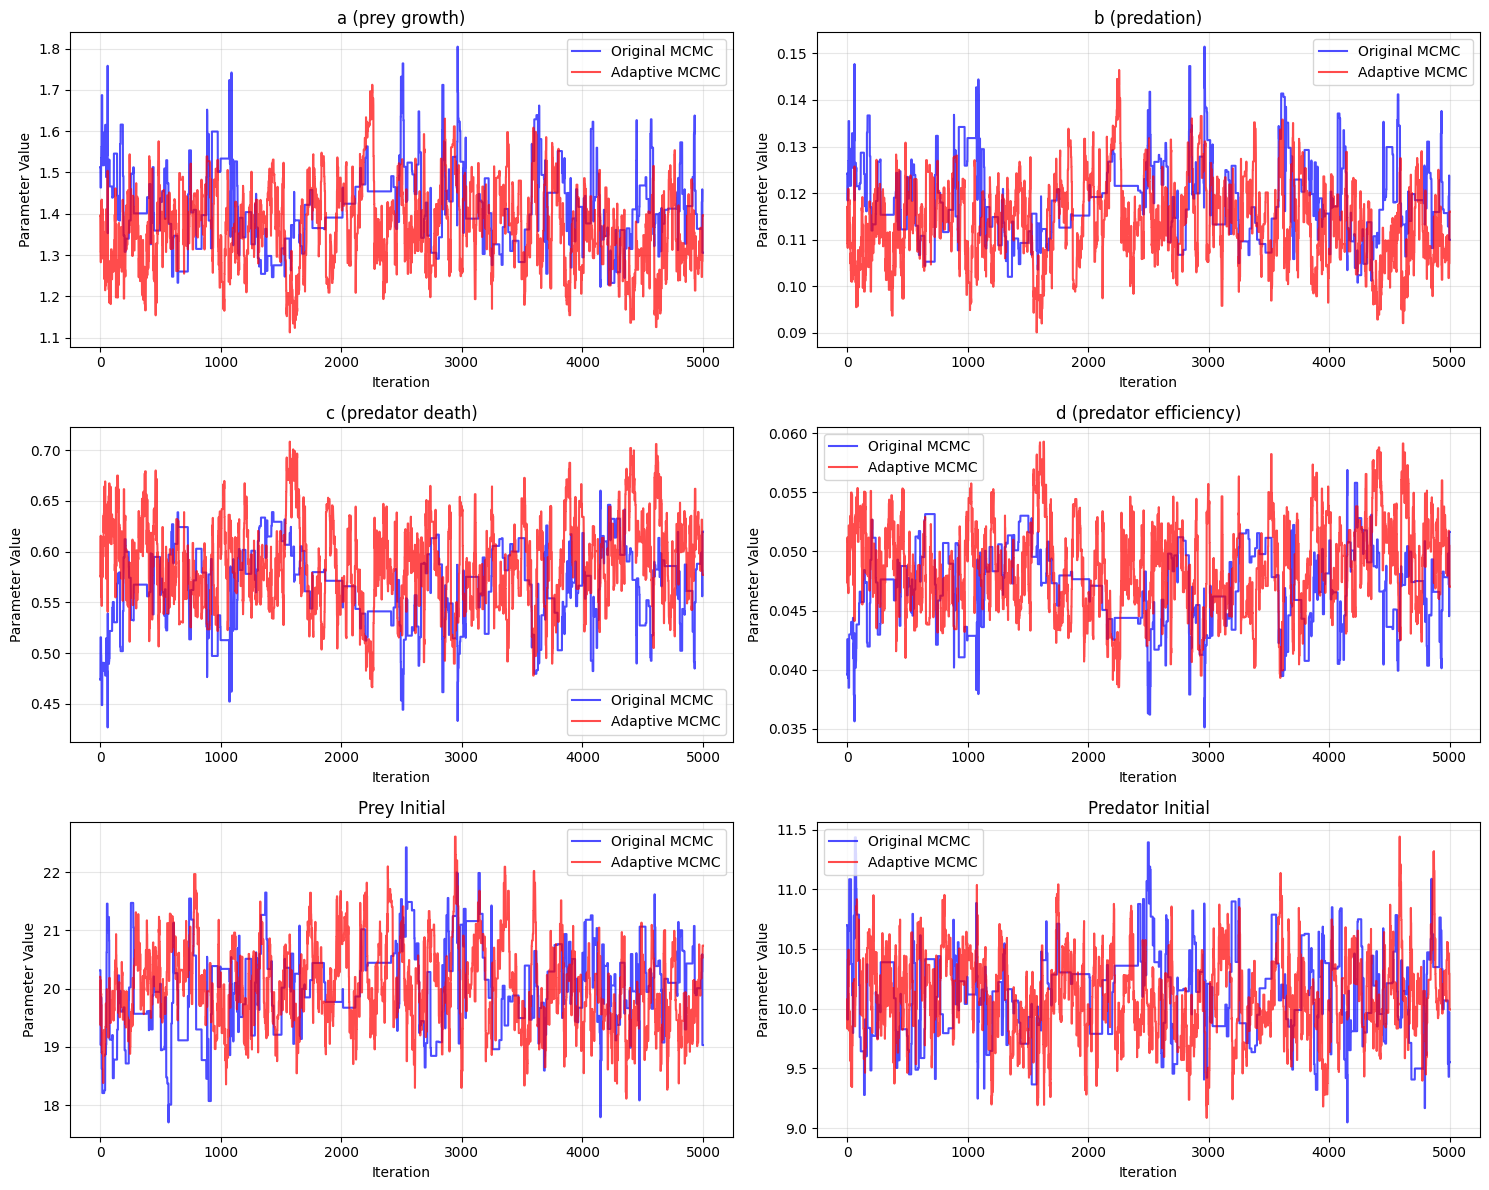


Comparison of parameter estimates (using last 500 samples):
Parameter		Original MCMC		Adaptive MCMC
-----------------------------------------------------------------
a (prey growth)     	1.4082±0.0927	1.3704±0.0998
b (predation)       	0.1179±0.0084	0.1141±0.0089
c (predator death)  	0.5685±0.0379	0.5864±0.0430
d (predator efficiency)	0.0471±0.0034	0.0486±0.0039
Prey Initial        	20.0995±0.7209	20.0340±0.7322
Predator Initial    	10.1226±0.3603	10.0992±0.3494


In [12]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
param_names = ['a (prey growth)', 'b (predation)', 'c (predator death)', 'd (predator efficiency)', 'Prey Initial', 'Predator Initial']

for i in range(6):
    ax = axes[i//2, i%2]
    
    ax.plot(samples[:, i], alpha=0.7, label='Original MCMC', color='blue')
    
    ax.plot(adaptive_samples[:, i], alpha=0.7, label='Adaptive MCMC', color='red')
    
    ax.set_title(f'{param_names[i]}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Parameter Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nComparison of parameter estimates (using last 500 samples):")
print("Parameter\t\tOriginal MCMC\t\tAdaptive MCMC")
print("-" * 65)
for i, name in enumerate(param_names):
    orig_mean = np.mean(samples[500:, i])
    orig_std = np.std(samples[500:, i])
    adapt_mean = np.mean(adaptive_samples[500:, i])
    adapt_std = np.std(adaptive_samples[500:, i])
    print(f"{name:<20}\t{orig_mean:.4f}±{orig_std:.4f}\t{adapt_mean:.4f}±{adapt_std:.4f}")

In [13]:
def fixed_covariance_mcmc(data, initial, model, t_eval, C_fixed, iterations=20000):
    
    # Extract only prey and pred columns
    data_values = data
    
    samples = [initial.copy()]
    current = initial.copy()
    accepted = 0
    
    start = time.time()
    
    print(f"Using covariance matrix with diagonal: {np.diag(C_fixed @ C_fixed.T)}")
    
    for i in trange(iterations, desc="Fixed Covariance MCMC"):
        proposal = prop(current, final_C)  
        alpha = acceptance_prob(current, proposal, t_eval, model, data_values, initial)
        
        if alpha > 0 and np.random.rand() < alpha:  # Simplified acceptance criterion
            current = proposal.copy()
            accepted += 1
        
        samples.append(current.copy())
    
    total_time = time.time() - start
    print(f"Final acceptance rate: {accepted/iterations:.3f}")
    print(f"Total runtime: {total_time:.1f} seconds")
    
    return np.array(samples)

In [14]:
long_initial = np.mean(adaptive_samples[-500:], axis=0)

print("Long MCMC initial guess (mean of last 500 adaptive samples):")
print(long_initial)
print("Difference from single last sample:", long_initial - adaptive_samples[-1])

long_samples = fixed_covariance_mcmc(data_est, long_initial, pred_prey_model, t_eval_est, final_C, iterations=50000)

print(f"\nLong MCMC samples shape: {long_samples.shape}")
print("Parameter means from long MCMC (using last 10,000 samples):")
for i, name in enumerate(param_names):
    print(f"{name}: {np.mean(long_samples[10000:, i]):.4f} ± {np.std(long_samples[10000:, i]):.4f}")

Long MCMC initial guess (mean of last 500 adaptive samples):
[ 1.32532098  0.11003509  0.60302283  0.05046251 19.70037157 10.22444542]
Difference from single last sample: [-0.07106316 -0.00599705  0.0259238   0.00345217 -1.0385332   0.23267817]
Using covariance matrix with diagonal: [9.86813021e-03 7.98874546e-05 1.83292169e-03 1.53728378e-05
 5.11184611e-01 1.17227829e-01]


Fixed Covariance MCMC: 100%|██████████| 50000/50000 [05:09<00:00, 161.80it/s]

Final acceptance rate: 0.359
Total runtime: 309.0 seconds

Long MCMC samples shape: (50001, 6)
Parameter means from long MCMC (using last 10,000 samples):
a (prey growth): 1.3578 ± 0.1072
b (predation): 0.1132 ± 0.0093
c (predator death): 0.5906 ± 0.0459
d (predator efficiency): 0.0492 ± 0.0041
Prey Initial: 19.8546 ± 0.7223
Predator Initial: 10.1404 ± 0.3935


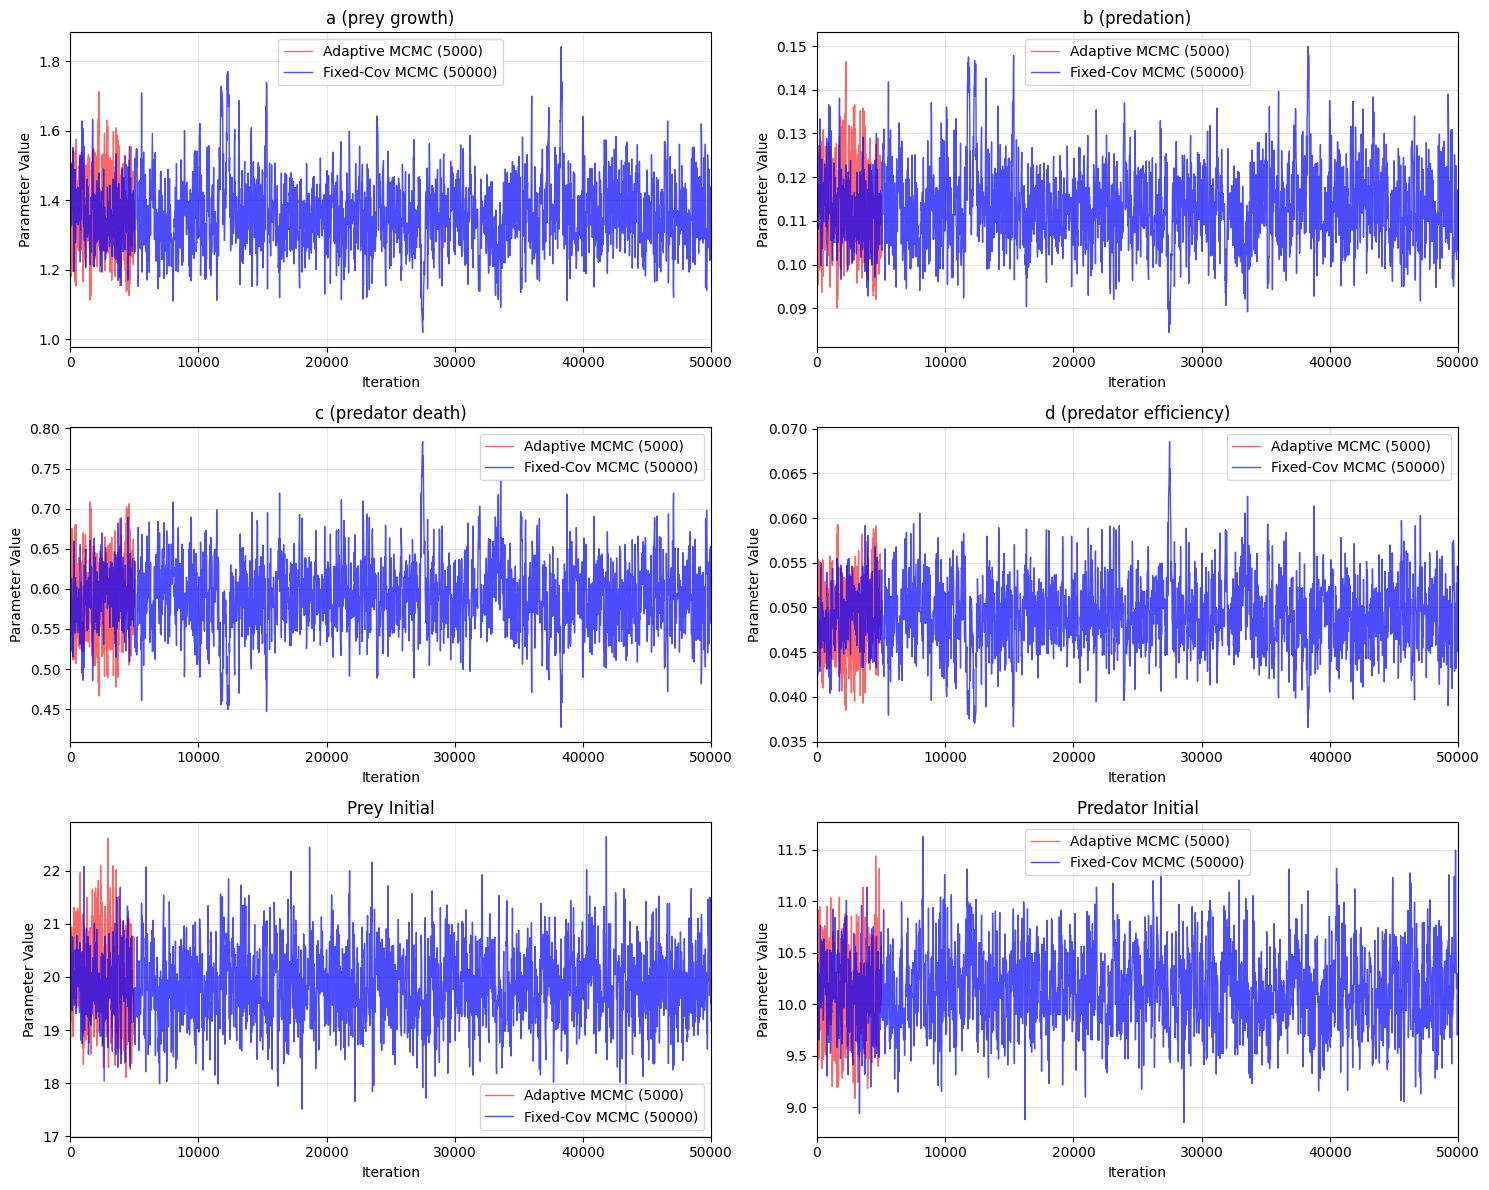


Comparison of parameter estimates from all three methods:
Parameter		Original (1000)		Adaptive (1000)		Long Fixed-Cov (50000)
-----------------------------------------------------------------------------------------------
a (prey growth)     	1.4082±0.0927		1.3704±0.0998		1.3578±0.1072
b (predation)       	0.1179±0.0084		0.1141±0.0089		0.1132±0.0093
c (predator death)  	0.5685±0.0379		0.5864±0.0430		0.5906±0.0459
d (predator efficiency)	0.0471±0.0034		0.0486±0.0039		0.0492±0.0041
Prey Initial        	20.0995±0.7209		20.0340±0.7322		19.8546±0.7223
Predator Initial    	10.1226±0.3603		10.0992±0.3494		10.1404±0.3935

Effective sample sizes:
Original MCMC: 4501 samples
Adaptive MCMC: 4501 samples
Long Fixed-Cov MCMC: 40001 samples


In [26]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

for i in range(6):
    ax = axes[i//2, i%2]    
    ax.plot(adaptive_samples[:, i], alpha=0.6, label='Adaptive MCMC (5000)', color='red', linewidth=1)
    
    subsample_indices = np.arange(0, len(long_samples), 20) 
    ax.plot(subsample_indices, long_samples[subsample_indices, i], alpha=0.7, 
            label='Fixed-Cov MCMC (50000)', color='blue', linewidth=1)
    ax.set_xlim(0, 50000)
    ax.set_title(f'{param_names[i]}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Parameter Value')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('synthetic_chains.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

print("\nComparison of parameter estimates from all three methods:")
print("Parameter\t\tOriginal (1000)\t\tAdaptive (1000)\t\tLong Fixed-Cov (50000)")
print("-" * 95)

for i, name in enumerate(param_names):
    orig_mean = np.mean(samples[500:, i])
    orig_std = np.std(samples[500:, i])
    
    adapt_mean = np.mean(adaptive_samples[500:, i])
    adapt_std = np.std(adaptive_samples[500:, i])
    
    long_mean = np.mean(long_samples[10000:, i])
    long_std = np.std(long_samples[10000:, i])
    
    print(f"{name:<20}\t{orig_mean:.4f}±{orig_std:.4f}\t\t{adapt_mean:.4f}±{adapt_std:.4f}\t\t{long_mean:.4f}±{long_std:.4f}")

print(f"\nEffective sample sizes:")
print(f"Original MCMC: {len(samples[500:])} samples")
print(f"Adaptive MCMC: {len(adaptive_samples[500:])} samples") 
print(f"Long Fixed-Cov MCMC: {len(long_samples[10000:])} samples")

Generating 95% confidence intervals for t=0 to t=40...


CI trajectories: 100%|██████████| 2000/2000 [00:15<00:00, 127.98it/s]


Generating 95% prediction intervals for t=0 to t=40...


PI trajectories: 100%|██████████| 2000/2000 [00:10<00:00, 195.63it/s]


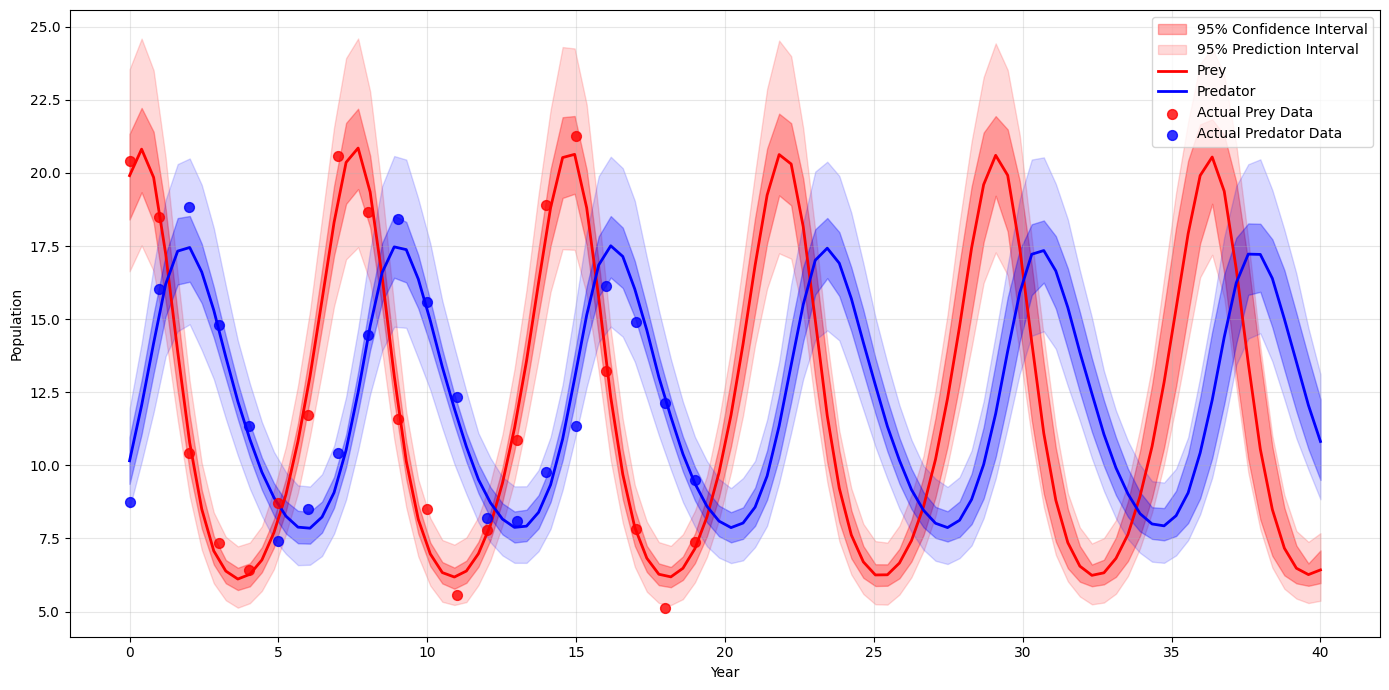

In [24]:
from tqdm import tqdm

burn_in_long = 1000
post_burn_long = long_samples[burn_in_long:]

n_samples_uncertainty = 2000
thin_step = max(1, post_burn_long.shape[0] // n_samples_uncertainty)
indices = np.arange(0, post_burn_long.shape[0], thin_step)[:n_samples_uncertainty]

# Time grid for full interval
t_full = np.linspace(0, 40, 100)

prey_traj_conf = []
pred_traj_conf = []
prey_traj_pred = []
pred_traj_pred = []

print("Generating 95% confidence intervals for t=0 to t=40...")
for idx in tqdm(indices, desc="CI trajectories"):
    params = post_burn_long[idx]
    sol = pred_prey_model(params, t_full)
    if sol.success:
        prey_traj_conf.append(sol.y[0])
        pred_traj_conf.append(sol.y[1])
best_params = np.mean(post_burn_long, axis=0)
sol = pred_prey_model(best_params, t_eval_est)
data_prey = np.maximum(data_est[:, 0], 1e-8)
data_pred = np.maximum(data_est[:, 1], 1e-8)
model_prey = np.maximum(sol.y[0], 1e-8)
model_pred = np.maximum(sol.y[1], 1e-8)
log_resid_prey = np.log(data_prey) - np.log(model_prey)
log_resid_pred = np.log(data_pred) - np.log(model_pred)
sigma_prey = np.std(log_resid_prey)
sigma_pred = np.std(log_resid_pred)
sigma = np.mean([sigma_prey, sigma_pred]) + 1e-6

print("Generating 95% prediction intervals for t=0 to t=40...")
for idx in tqdm(indices, desc="PI trajectories"):
    params = post_burn_long[idx].copy()
    sol = pred_prey_model(params, t_full)
    if sol.success:
        prey_traj_pred.append(sol.y[0] * np.exp(np.random.normal(0, sigma, size=sol.y[0].shape)))
        pred_traj_pred.append(sol.y[1] * np.exp(np.random.normal(0, sigma, size=sol.y[1].shape)))

prey_traj_conf = np.array(prey_traj_conf)
pred_traj_conf = np.array(pred_traj_conf)
prey_traj_pred = np.array(prey_traj_pred)
pred_traj_pred = np.array(pred_traj_pred)
prey_mean = np.mean(prey_traj_pred, axis=0)
pred_mean = np.mean(pred_traj_pred, axis=0)
# Compute 95% CI (2.5th and 97.5th percentiles)
prey_ci_lower, prey_ci_upper = np.percentile(prey_traj_conf, [2.5, 97.5], axis=0)
pred_ci_lower, pred_ci_upper = np.percentile(pred_traj_conf, [2.5, 97.5], axis=0)

# Compute 95% PI (2.5th and 97.5th percentiles)
prey_pi_lower, prey_pi_upper = np.percentile(prey_traj_pred, [2.5, 97.5], axis=0)
pred_pi_lower, pred_pi_upper = np.percentile(pred_traj_pred, [2.5, 97.5], axis=0)

plt.figure(figsize=(14, 7))

# Prey
plt.fill_between(t_full, prey_ci_lower, prey_ci_upper, color='red', alpha=0.3, label = "95% Confidence Interval")
plt.fill_between(t_full, prey_pi_lower, prey_pi_upper, color='red', alpha=0.15, label = "95% Prediction Interval")
plt.plot(t_full, prey_mean, color='red', linewidth=2, label='Prey')


# Predator
plt.fill_between(t_full, pred_ci_lower, pred_ci_upper, color='blue', alpha=0.3)
plt.fill_between(t_full, pred_pi_lower, pred_pi_upper, color='blue', alpha=0.15)
plt.plot(t_full, pred_mean, color='blue', linewidth=2, label='Predator')


# Data points (only for t=0-20)
plt.scatter(t_eval_est, data_est[:, 0], color='red', s=50, alpha=0.8, label='Actual Prey Data', zorder=5)
plt.scatter(t_eval_est, data_est[:, 1], color='blue', s=50, alpha=0.8, label='Actual Predator Data', zorder=5)

plt.savefig('synthetic_bayesian.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

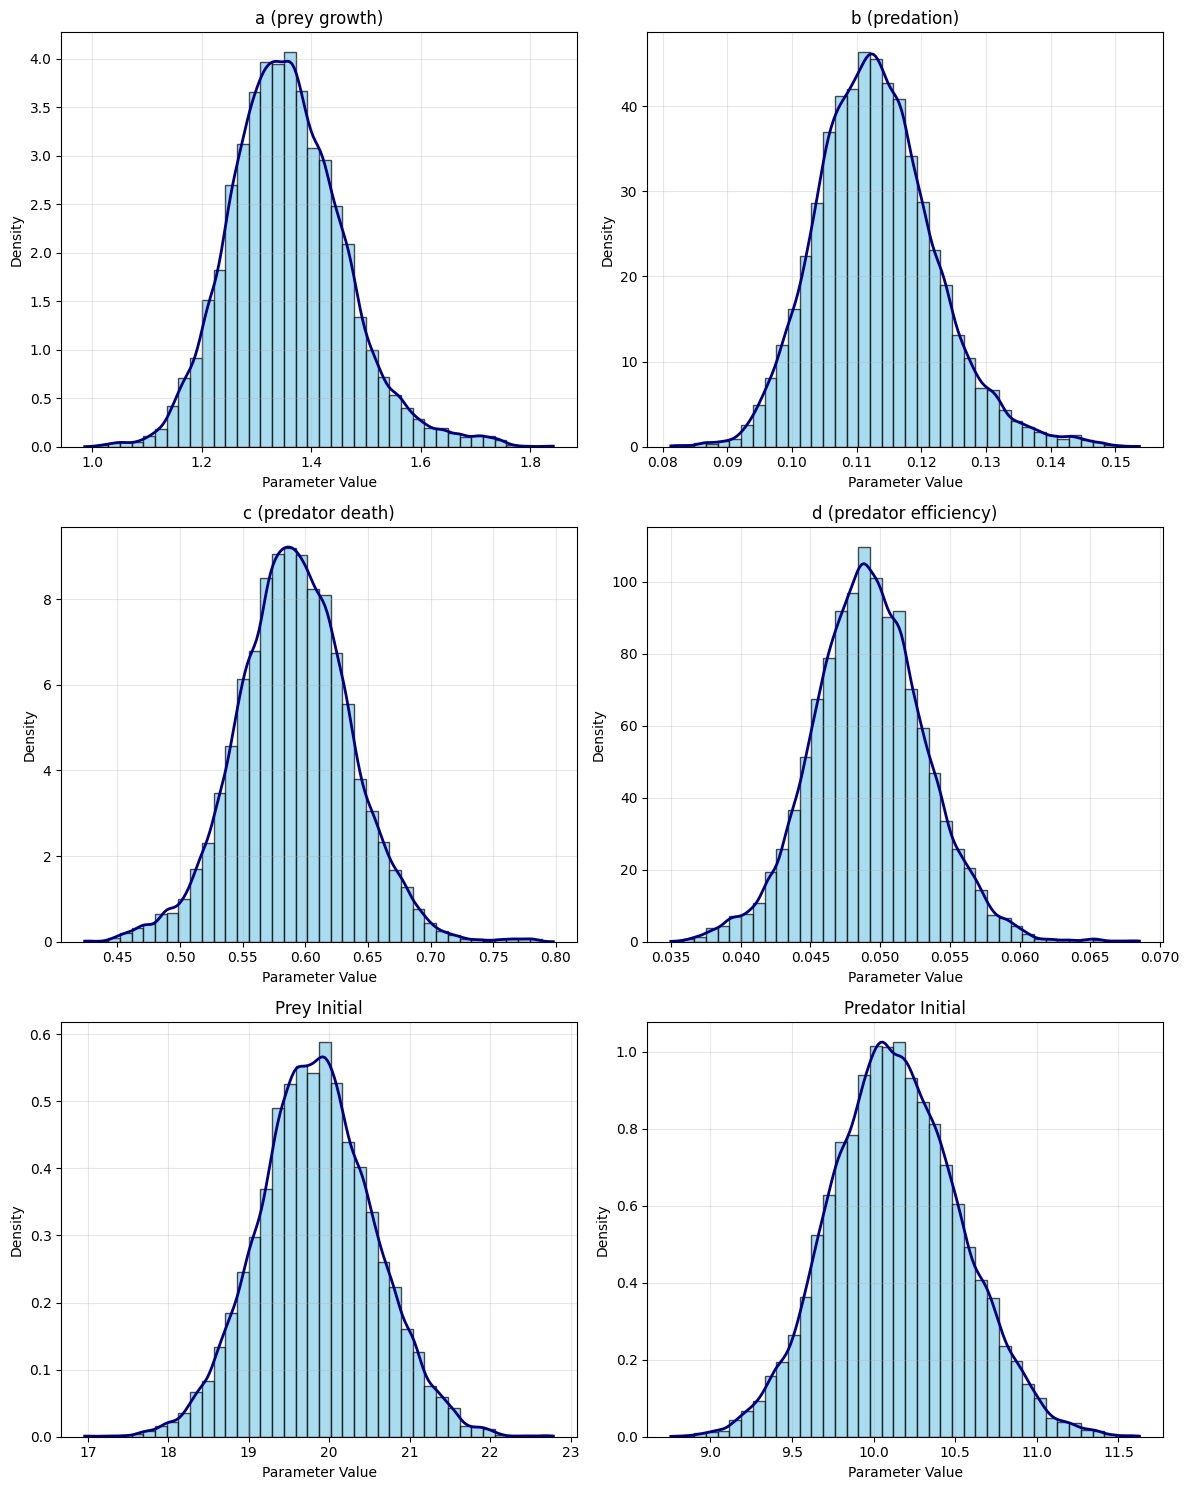

In [ ]:
import scipy.stats as stats

fig, axes = plt.subplots(3, 2, figsize=(12, 15))
param_names = ['a (prey growth)', 'b (predation)', 'c (predator death)', 'd (predator efficiency)', 'Prey Initial', 'Predator Initial']

for i, ax in enumerate(axes.flat):
    data_i = post_burn_long[:, i]
    counts, bins, _ = ax.hist(data_i, bins=40, color='skyblue', edgecolor='black', alpha=0.7, density=True)
    kde = stats.gaussian_kde(data_i)
    x_vals = np.linspace(np.min(data_i), np.max(data_i), 200)
    ax.plot(x_vals, kde(x_vals), color='navy', linewidth=2)
    ax.set_title(f'{param_names[i]}')
    ax.set_xlabel('Parameter Value')
    ax.set_ylabel('Density')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('synthetic_posterior.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

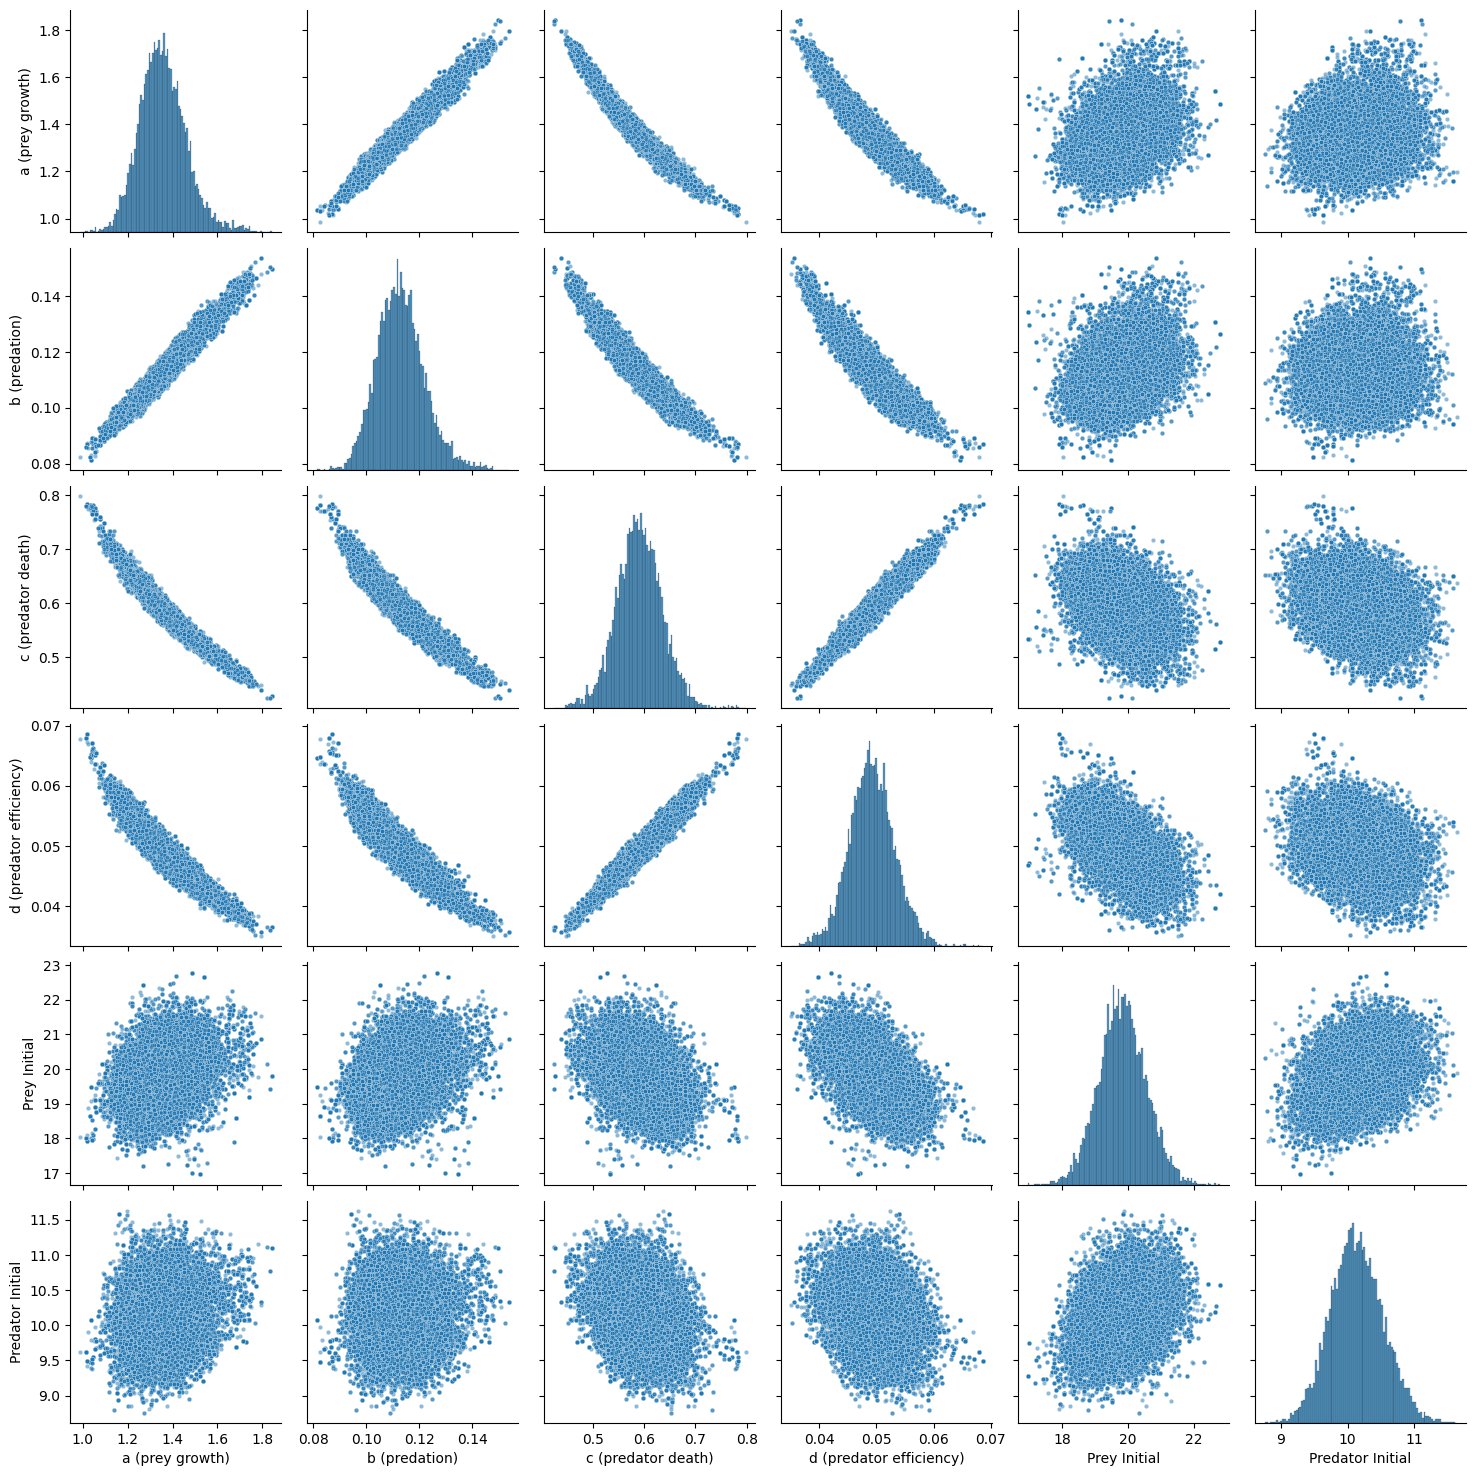

In [23]:
param_names_corr = ['a (prey growth)', 'b (predation)', 'c (predator death)', 'd (predator efficiency)', 'Prey Initial', 'Predator Initial']
df_params = pd.DataFrame(post_burn_long, columns=param_names_corr)

sns.pairplot(df_params, diag_kind='hist', plot_kws={'alpha':0.5, 's':10})
plt.savefig('synthetic_covariance.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

In [19]:
np.save('synthetic_samples.npy', post_burn_long)